In [1]:
import os
import sys
import skimage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import time

PKG_DIR = "./"
# PKG_DIR = "/project/bioinformatics/Xiao_lab/s181141/Packages"
sys.path.append(PKG_DIR)

from DIPModels.unet import model as unet_model
from DIPModels.unet import config as unet_config
from DIPModels.unet import utils as unet_utils

from DIPModels.utils_g import utils_image
from DIPModels.utils_g import utils_keras
from DIPModels.utils_g import utils_misc

from utils_nuclei import *

%matplotlib inline 
%load_ext autoreload

#import warnings;
#warnings.simplefilter('ignore')

C:\Users\richa\Anaconda3\envs\tf_try\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%autoreload 2
## Load training config and model
MODEL_DIR = "./UNet2D_logs/"
training_config = unet_config.Config(
    NAME='nuclei', 
    NUM_CLASSES=5,
    MODEL_INPUT_SIZE=(512, 512),
    
    ENCODER = 'ResNet',
    #FILTER_SIZE=[4, 8, 16],
    ENCODER_USE_BN = True,
    ARCHITECTURE = 'resnet101',
    
    DECODER = 'UNet',
    UPSAMPLING_MODE = 'nearest',
    DECODER_USE_BN = True,
    
    DROPOUT_RATE=0.0,
    
    # batch_size = gpu_count * images_per_gpu
    GPU_COUNT=1,
    IMAGES_PER_GPU=3,
    VALIDATION_STEPS=None, 
    STEPS_PER_EPOCH=None,
    LEARNING_RATE=1e-4, # for adam
)
training_config.display()

# Load pre-trained weights
ZF_MODEL_PATH = os.path.join(PKG_DIR, "./pretrained/zf_unet_224.h5")
# LAST_MODEL = os.path.join(MODEL_DIR, "nuclei_unet20180522T1033", "nuclei_unet_0001.h5")

weights_path = ZF_MODEL_PATH
model = unet_model.UNet(model_dir=MODEL_DIR, config=training_config, weights_path=None)
model.keras_model.summary()


Configurations:
ARCHITECTURE                   resnet101
BATCH_SIZE                     3
DECODER                        UNet
DECODER_USE_BN                 True
DROPOUT_RATE                   0.0
ENCODER                        ResNet
ENCODER_USE_BN                 True
FILTER_SIZE                    (32, 64, 128, 256, 512, 1024)
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   [1. 1.]
MODEL_INPUT_SIZE               (512, 512)
NAME                           nuclei
NUM_CLASSES                    5
STEPS_PER_EPOCH                None
UPSAMPLING_MODE                nearest
VALIDATION_STEPS               None
WEIGHT_DECAY                   0.0001


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to              

In [3]:
%autoreload 2
##  Training dataset
# Default parameters for processor
args = dict(model_input_size=training_config.MODEL_INPUT_SIZE,
            mean=utils_image.IMAGE_NET_MEAN_TF,
            std=utils_image.IMAGE_NET_STD_TF,
            maximum_num_masks=100000,
            edge_pad_size=[(0,0), (0,0)],
            fill_mode='constant', cval=0.)

processor = TrainProcessor(rescale=False, standardize=True, augment=True, resize=True, args=args)

#additional dataset parameters to add diversity to training sequences
tf_args = dict(rotation=90., shear=0., 
               width_zoom=0.2, height_zoom=0.2,
               width_shift=0., height_shift=0., 
               horizontal_flip=True, vertical_flip=True)

#Original: train_dir = "./data/stage1_train/"
train_dir = "../Adenocarcinoma Slides/Dataset/"
#dataset_train = TrainDataset(source=['DSB_2018'], classes=['tumor', 'erythrocyte', 'lymphocyte', 'stroma'])
#dataset_train(image_dir=train_dir, processor=processor, tf_args=tf_args)
dataset_train = unet_model.dataset(training_config,train_dir)
dataset_train.remove_background(train_dir)

## Validation dataset
args = dict(model_input_size=training_config.MODEL_INPUT_SIZE,
            mean=utils_image.IMAGE_NET_MEAN_TF,
            std=utils_image.IMAGE_NET_STD_TF,
            maximum_num_masks=100000,
            fill_mode='constant', cval=0.)

processor = TrainProcessor(rescale=False, standardize=True, augment=False, resize=True, args=args)

valid_dir = "../Adenocarcinoma Slides/Dataset/"
#dataset_valid = ValidDataset(source=['DSB_2018'], classes=['tumor', 'erythrocyte', 'lymphocyte', 'stroma'])
#dataset_valid(image_dir=valid_dir, processor=processor, tf_args=None)
dataset_valid = unet_model.dataset(training_config,valid_dir)


In [4]:
%autoreload 2
# Load and display dataset_train and dataset_val, Debug Only
image_ids = np.random.choice(dataset_train.image_ids, 2) # take two arbitrary image ids
#image_ids = ['7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072', 
#             '0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1', 
#             '0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6', 
#             'c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441']
'''
for image_id in image_ids:
    print(image_id)
    image, mask = data_train.load_image(image_id)
    image_info = dataset_train.images[image_id]
    image_raw = skimage.io.imread(image_info['data'][0])[..., :3]
    masks_raw = utils_misc.read_masks_from_dir(image_info['data'][1])
    
    image_train, (masks_train, class_ids_train) = dataset_train.load_data(image_id)
    utils_misc.plot_image_masks(image_raw, masks_raw, image_train, masks_train)
    print("Train: " + str(masks_train.shape))

    image_valid, (masks_valid, class_ids_valid) = dataset_valid.load_data(image_id)
    utils_misc.plot_image_masks(image_raw, masks_raw, image_valid, masks_valid)
    print("Eval: " + str(masks_valid.shape))
'''

'\nfor image_id in image_ids:\n    print(image_id)\n    image, mask = data_train.load_image(image_id)\n    image_info = dataset_train.images[image_id]\n    image_raw = skimage.io.imread(image_info[\'data\'][0])[..., :3]\n    masks_raw = utils_misc.read_masks_from_dir(image_info[\'data\'][1])\n    \n    image_train, (masks_train, class_ids_train) = dataset_train.load_data(image_id)\n    utils_misc.plot_image_masks(image_raw, masks_raw, image_train, masks_train)\n    print("Train: " + str(masks_train.shape))\n\n    image_valid, (masks_valid, class_ids_valid) = dataset_valid.load_data(image_id)\n    utils_misc.plot_image_masks(image_raw, masks_raw, image_valid, masks_valid)\n    print("Eval: " + str(masks_valid.shape))\n'

[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype('float32'), 1.0, 0.0, 254504.94]
[(512, 512, 4), dtype('float32'), 1.0, 0.0, 71528.0]


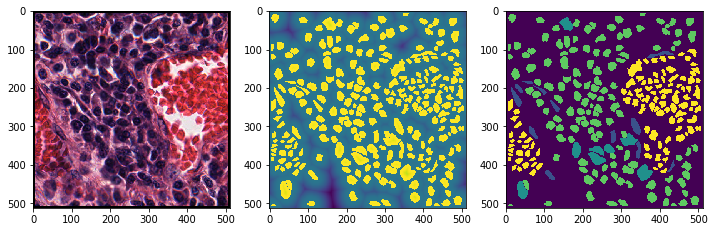

In [5]:
%autoreload 2
train_sequence = unet_model.DataSequence(dataset_train, batch_size=2, # training_config.BATCH_SIZE,
                                         config=training_config,
                                         use_border_weights=True, use_class_weights=False,
                                         border_weights_sigma=32,
                                         shuffle=True)


#batch_images, batch_masks = train_sequence[image_ids[0]]
#print([batch_images.shape, batch_images.dtype, batch_images.max(), batch_images.min()])
#print([batch_masks.shape, batch_masks.dtype, batch_masks.max(), batch_masks.min(), np.sum(batch_masks)])

for x, y in train_sequence:
    #batch_images = first image of batch
    batch_images = x[0]
    #batch_bg_masks, batch_cl_masks =y[0], y[1]
    batch_bg_masks = y[0][0]
    batch_cl_masks = y[1][0]
    print([batch_images.shape, batch_images.dtype, batch_images.max(), batch_images.min()])
    print([batch_bg_masks.shape, batch_bg_masks.dtype, batch_bg_masks.max(), batch_bg_masks.min(), np.sum(batch_bg_masks)])
    print([batch_cl_masks.shape, batch_cl_masks.dtype, batch_cl_masks.max(), batch_cl_masks.min(), np.sum(batch_cl_masks)])
    break # check that first image works, can be removed to traverse all batches

fig, axes = plt.subplots(1, 3, figsize=[4 * 3, 4], sharex=False, sharey=False)
ax = axes.ravel()
#ax[0].imshow(skimage.exposure.rescale_intensity(batch_images, out_range=(0,1)))
ax[0].imshow(batch_images)
ax[1].imshow(utils_misc.masks_to_image(batch_bg_masks,labels='all'))
ax[2].imshow(utils_misc.masks_to_image(batch_cl_masks, labels='all'))


In [18]:
%autoreload 2
# Train the network without using border weights first, 
model.train(dataset_train, dataset_valid, epochs=1, use_border_weights=False, use_class_weights=False)
#print([layer.trainable for layer in model.keras_model.layers])


Starting at epoch 0. lr=0.0001

Checkpoint Path: ./UNet2D_logs/nuclei_ResNet_UNet20180724T1743\nuclei_ResNet_UNet_{epoch:04d}.h5
Epoch 1/1
11106_1_1011003_2_911003_2_4  61497
49026
 71528
11105_2_4 31980
11106_2_1 65963
11003_2_2 77145
11105_2_4 31980
11106_1_10 49026
11106_1_10 49026
11105_2_4 31980
11003_1_9 73740
11003_2_9 61497
3/4 [=====================>........] - ETA: 2:15 - loss: 0.4332 - bg_logits_loss: 0.8663 - cl_logits_loss: 0.4122 - bg_logits_bg_iou_metrics: 0.2978 - cl_logits_cl_iou_metrics: 0.888911003_2_4 71528
11106_2_5 46847
11003_2_2 77145
11106_1_10 49026
11106_1_4 67865
11106_1_10 49026
11105_2_4 31980
11106_1_4 67865
11105_2_4 31980
11105_2_4 31980
11003_1_6 58422
11106_2_1 65963
11106_2_5 46847
11106_2_111003_2_9 65963
 61497
11003_1_9 73740
11106_1_10 49026
11105_2_4 31980
11003_1_9 7374011003_2_2
 77145
11003_2_4 71528
11003_1_6 58422
11106_1_4 67865
11003_2_9 61497
11106_1_10 49026
11003_2_2 77145
11003_2_4 71528
11106_1_4 67865
11003_2_9 61497
11106_2_1 6596

In [7]:
myDict = {'hi':1, 'name':2}
keys = np.asarray(list(myDict))
print(keys)

myList = np.asarray([3,2,1,0])
print(myList[1:])

print([1] + [2,3])

['hi' 'name']
[2 1 0]
[1, 2, 3]


In [8]:
x = skimage.io.imread("../Adenocarcinoma Slides/Dataset/11003_2_2/11003_2_2.png")
print(x)

[[[133  94 124]
  [166 106 143]
  [145  85 122]
  ...
  [204 174 227]
  [164 134 187]
  [128  86 161]]

 [[ 99  60  88]
  [159  83 128]
  [178 102 147]
  ...
  [199 156 217]
  [161 118 179]
  [117  75 156]]

 [[ 87  48  76]
  [131  66 110]
  [164  99 143]
  ...
  [190 150 212]
  [160 120 182]
  [109  72 155]]

 ...

 [[109  56 118]
  [126  55 109]
  [128  57 111]
  ...
  [121  60 106]
  [108  47  93]
  [ 98  41  88]]

 [[ 86  36  91]
  [ 77  37  81]
  [ 86  46  90]
  ...
  [116  79 124]
  [101  64 109]
  [109  48  93]]

 [[ 67  18  65]
  [ 34  23  58]
  [ 49  38  73]
  ...
  [150  96 126]
  [131  77 107]
  [118  56 107]]]


In [17]:
arr1 = np.asarray([1,2,3])
arr2 = np.asarray([4,5,6])
arr3 = np.asarray([7,8,9])
arr2D = np.asarray([arr1,arr2,arr3])
print(arr2D)
for a in np.nditer(arr2D, op_flags=['readwrite']):
    print(a)
    a[...] = 10-a
print(arr2D)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
1
2
3
4
5
6
7
8
9
[[9 8 7]
 [6 5 4]
 [3 2 1]]
1
2
3


(512, 512, 3)


749896

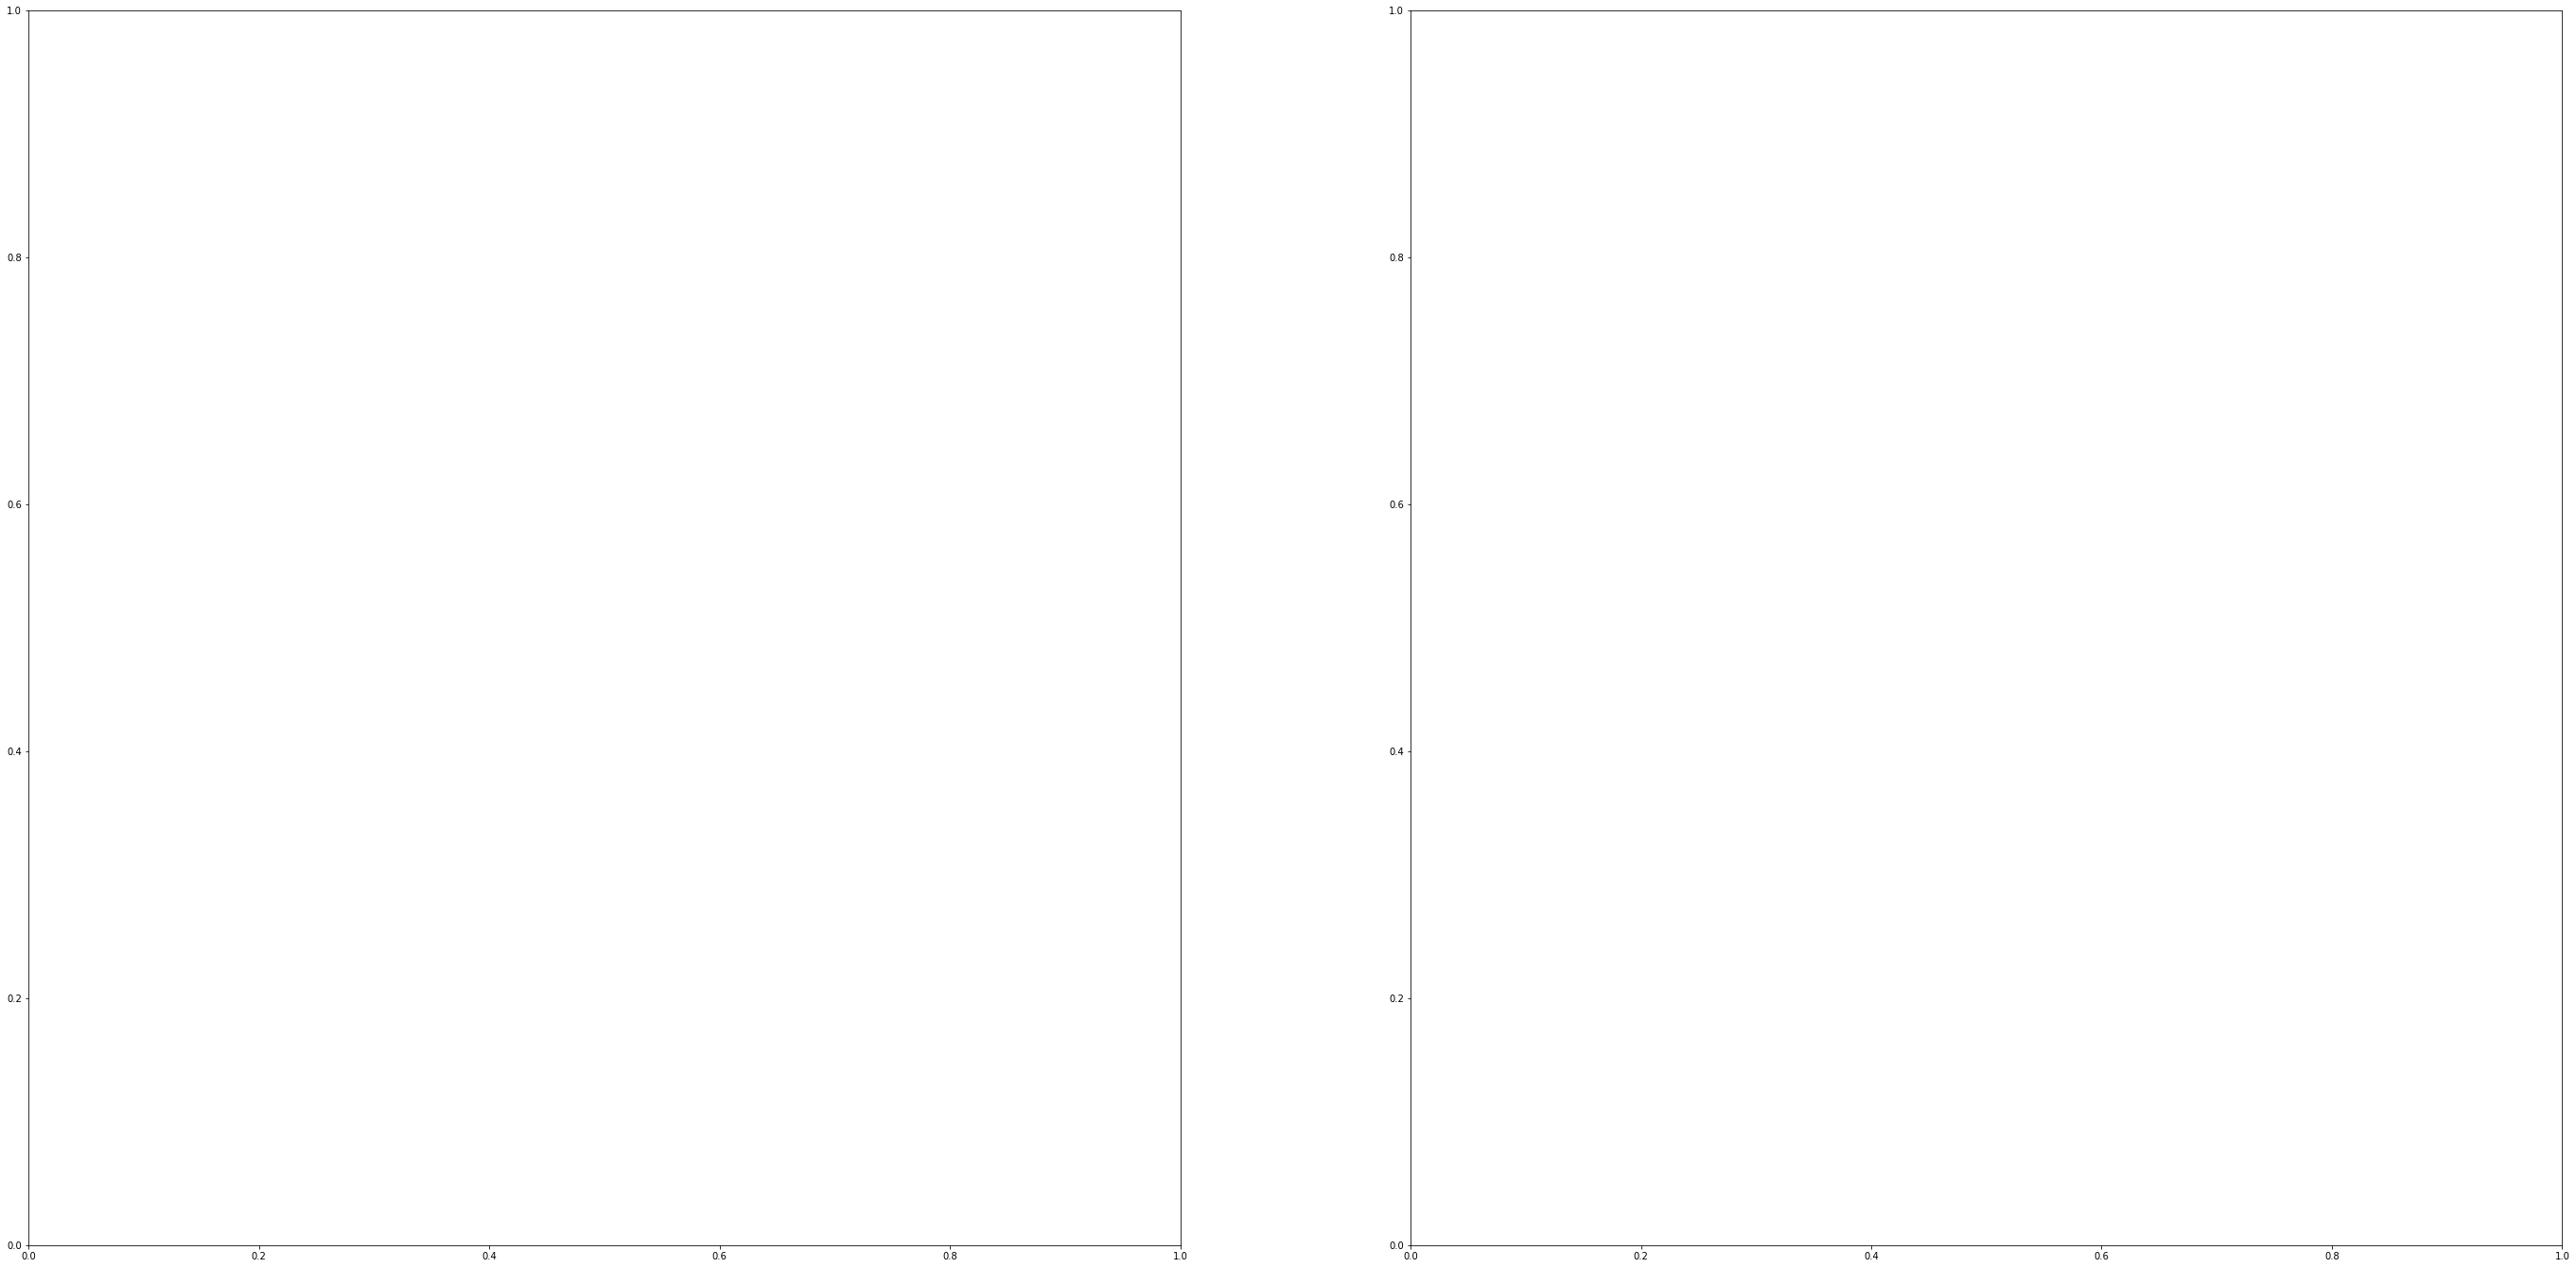

In [11]:
fig, axes = plt.subplots(1, 2, figsize=[48, 24], sharex=False, sharey=False)
ax = axes.ravel()
print(batch_images.shape)
np.sum(batch_images !=0)
#ax[0].imshow(batch_masks)

In [12]:
dataset_train.image_ids

['11003_1_6',
 '11003_1_9',
 '11003_2_2',
 '11003_2_4',
 '11003_2_9',
 '11105_2_4',
 '11106_1_10',
 '11106_1_4',
 '11106_2_1',
 '11106_2_5']

In [14]:
%autoreload 2
train_sequence = unet_model.DataSequence(dataset_train, batch_size=2, # training_config.BATCH_SIZE,
                                         config=training_config,
                                         use_border_weights=True, use_class_weights=False,
                                         border_weights_sigma=32,
                                         shuffle=False)
print(dataset_train.image_ids)
print(train_sequence.__len__())
#batch_images, batch_masks = train_sequence[image_ids[0]]
#print([batch_images.shape, batch_images.dtype, batch_images.max(), batch_images.min()])
#print([batch_masks.shape, batch_masks.dtype, batch_masks.max(), batch_masks.min(), np.sum(batch_masks)])

i = 1
for x, y in train_sequence:
    #batch_images, batch_masks = first image of batch, first mask logits
    batch_images = x[0]
    #batch_bg_masks, batch_cl_masks =y[0], y[1]
    batch_bg_masks = y[0][0]
    #print("bath %s: " % i)
    print([x.shape, y[0].shape, y[1].shape])
    print([batch_images.shape, batch_images.dtype, batch_images.max(), batch_images.min()])
    print([batch_bg_masks.shape, batch_bg_masks.dtype, batch_bg_masks.max(), batch_bg_masks.min(), np.sum(batch_bg_masks)])
    i += 1
    if i > 7:
        break

['11003_1_6', '11003_1_9', '11003_2_2', '11003_2_4', '11003_2_9', '11105_2_4', '11106_1_10', '11106_1_4', '11106_2_1', '11106_2_5']
5
[(2, 512, 512, 3), (2, 512, 512, 2), (2, 512, 512, 4)]
[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype('float32'), 1.0, 0.0, 239805.83]
[(2, 512, 512, 3), (2, 512, 512, 2), (2, 512, 512, 4)]
[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype('float32'), 1.0, 0.0, 252047.38]
[(2, 512, 512, 3), (2, 512, 512, 2), (2, 512, 512, 4)]
[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype('float32'), 1.0, 0.0, 248868.92]
[(2, 512, 512, 3), (2, 512, 512, 2), (2, 512, 512, 4)]
[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype('float32'), 1.0, 0.0, 238072.36]
[(2, 512, 512, 3), (2, 512, 512, 2), (2, 512, 512, 4)]
[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype('float32'), 1.0, 0.0, 248587.22]
[(2, 512, 512, 3), (2, 512, 512, 2), (2, 512, 512, 4)]
[(512, 512, 3), dtype('uint8'), 255, 0]
[(512, 512, 2), dtype

In [15]:
import keras.utils

myArr = np.array([255,510,255,1020,255,510])
print(myArr)
normalArr = keras.utils.normalize(myArr)
normalArr[0][:3] += 1
print(normalArr)
a = keras.utils.to_categorical(normalArr,num_classes=3)
print(a)

[ 255  510  255 1020  255  510]
[[1.19245009 1.38490018 1.19245009 0.76980036 0.19245009 0.38490018]]
[[[0. 1. 0.]
  [0. 1. 0.]
  [0. 1. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]]


In [16]:
myList = [1,2,3,4,5,6]
print(myList[:4])
print(myList[2:])

[1, 2, 3, 4]
[3, 4, 5, 6]


In [20]:
myString = "Hello World.png"
print(myString[:-4])

Hello World
